# Implementation of YIN Algorithm

https://github.com/NValsted/VForScienceProjects/blob/master/YIN_pitch_detection/pitch_detection.py

In [1]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def f(x):
    f_0 = 1
    envelope = lambda x: np.exp(-x)
    return np.sin(2*np.pi*f_0*x) * envelope(x)

# def ACF( f, W, t, lag):
#     return np.sum( f[t : t + W] * f[lag + t : lag + t + W] )

def ACF(f, W, t, lag):
    corr = np.correlate(f[t : t + W], f[lag + t : lag + t + W], mode = 'valid')
    return corr[0]



def DF(f , W, t, lag):
    return ACF(f, W, t, 0) + ACF(f, W, t + lag, 0) - (2 * ACF(f, W, t, lag))

def CMNDF(f, W, t , lag):
    if lag == 0:
        return 1
    return DF(f, W, t, lag) / np.sum([DF(f, W, t, j+1) for j in range(lag)]) * lag

#############################################

def memo_CMNDF(f, W, t, lag_max):
    running_sum = 0
    vals = []
    for lag in range(0, lag_max):
        if lag == 0:
            vals.append(1)
            running_sum += 0
        else:
            running_sum += DF(f, W, t, lag)
            vals.append(DF(f, W, t, lag) / running_sum * lag)
    return vals

In [3]:
def detect_pitch( f, W, t, sample_rate, bounds, thresh = 0.1):
    CMNDF_vals = [CMNDF(f, W, t, i) for i in range(*bounds)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]


    return sample_rate / sample

#####################################################
def augmented_detect_pitch_CMNDF(f, W, t, sample_rate, bounds, thresh=0.1):  # Also uses memoization
    CMNDF_vals = memo_CMNDF(f, W, t, bounds[-1])[bounds[0]:]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]
    return sample_rate / (sample + 1)

In [131]:
# Numpy array of all note frequencies from C2 to B6
noteFrequencies = np.array([65.41,  69.30,  73.42,  77.78,  82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 123.47,
                            130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00, 233.08, 246.94,
                            261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,
                            523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77,
                            1046.50, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53])

# Numpy array of intermediate frequencies between each note
halfFrequencies = np.array([np.mean([noteFrequencies[i], noteFrequencies[i+1]]) for i in range(len(noteFrequencies)-1)])

# Dictionary of RGB colors for each note, using the same color for each octave
noteColors = {halfFrequencies[i]: plt.cm.tab20(i % 12) for i in range(len(halfFrequencies))}

note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Function that plots the note intervals in color using same color for note octaves
def plot_note_intervals(fmin, fmax):
    idmin = np.abs(noteFrequencies - fmin).argmin()
    idmin = idmin - 2 if noteFrequencies[idmin] > fmin else idmin - 1
    idmax = np.abs(noteFrequencies - fmax).argmin()
    idmax = idmax if noteFrequencies[idmax] < fmax else idmax - 1

    for i in range(idmin, idmax):
        plt.axhspan(halfFrequencies[i], halfFrequencies[i+1], color=noteColors[halfFrequencies[i]], alpha=0.2)
        # Show note names in the middle of the interval
        if fmin < noteFrequencies[i+1] < fmax:
            plt.text(0, noteFrequencies[i+1], note_names[(i+1) % 12] + str((i+1) // 12 + 2), fontsize=14, ha='right', va='center')


In [60]:
sample_rate = 500
start = 0
end = 5
num_samples = int(sample_rate*(end-start)+1)
windows_size = int(2 / 5 * 500)
bounds = [20, num_samples//2]

x = np.linspace(start, end, num_samples)

print(detect_pitch(f(x), windows_size, 1, sample_rate, bounds))

1.002004008016032


In [61]:
sample_rate, data = wavfile.read(f'audios\singer.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [ 20, 2000 ]

pitches_memo = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches_memo.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

100%|██████████| 947/947 [00:21<00:00, 44.85it/s]


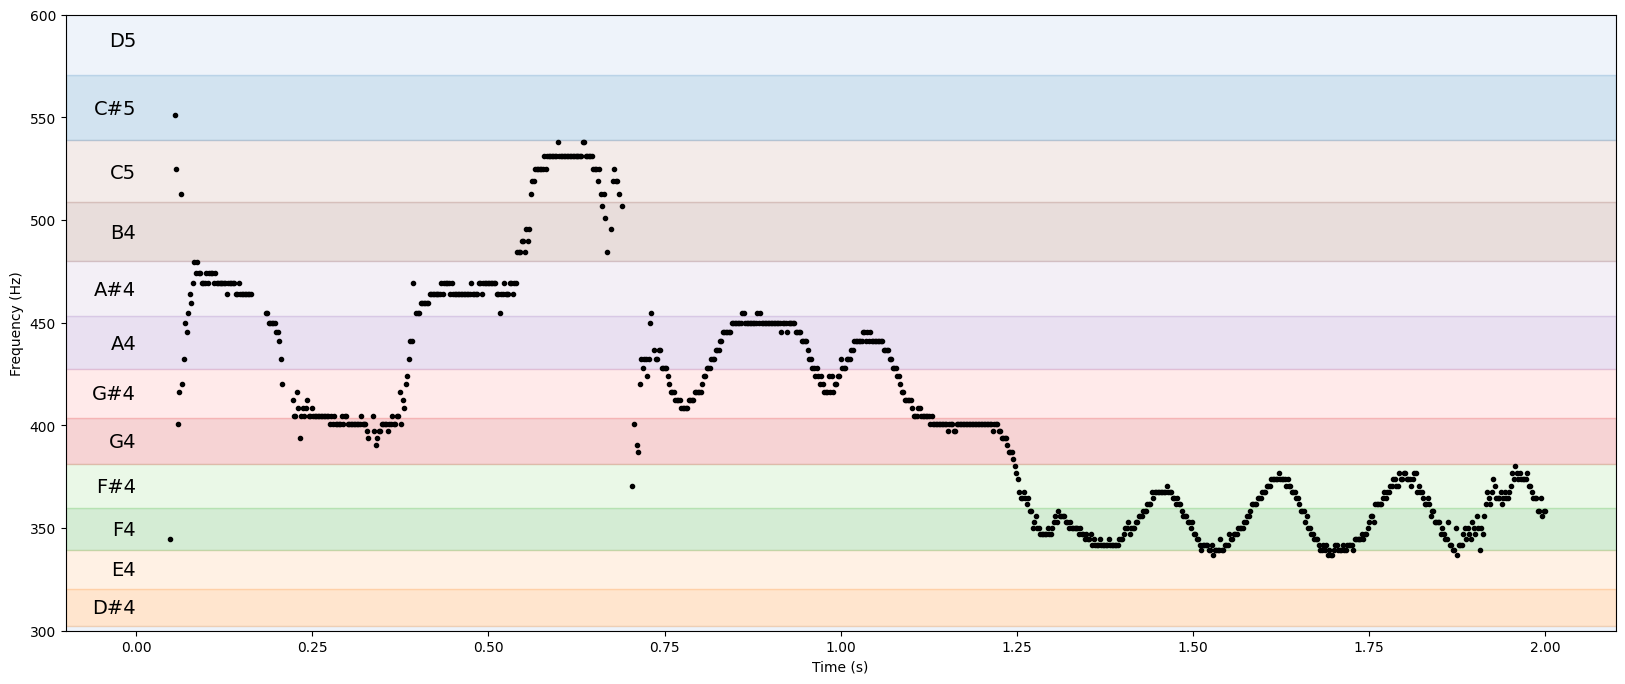

In [132]:
x_memo = np.linspace(0, len(data)//sample_rate, num=len(pitches_memo))
plt.figure(figsize=(20,8))
# Draw rectangles to show different notes, dividing the space between 2 notes in half for each step
plot_note_intervals(fmin=300, fmax=600)
plt.plot(x_memo,pitches_memo,'.k')
plt.ylim(300,600)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [17]:
sample_rate, data = wavfile.read(f'audios\singer.wav')
data = data.astype(np.float64)
windows_size = int(5 / 600 * 44100)
bounds = [ 20 , 600 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(detect_pitch(data, windows_size, i * windows_size, sample_rate, bounds))

100%|██████████| 289/289 [05:03<00:00,  1.05s/it]


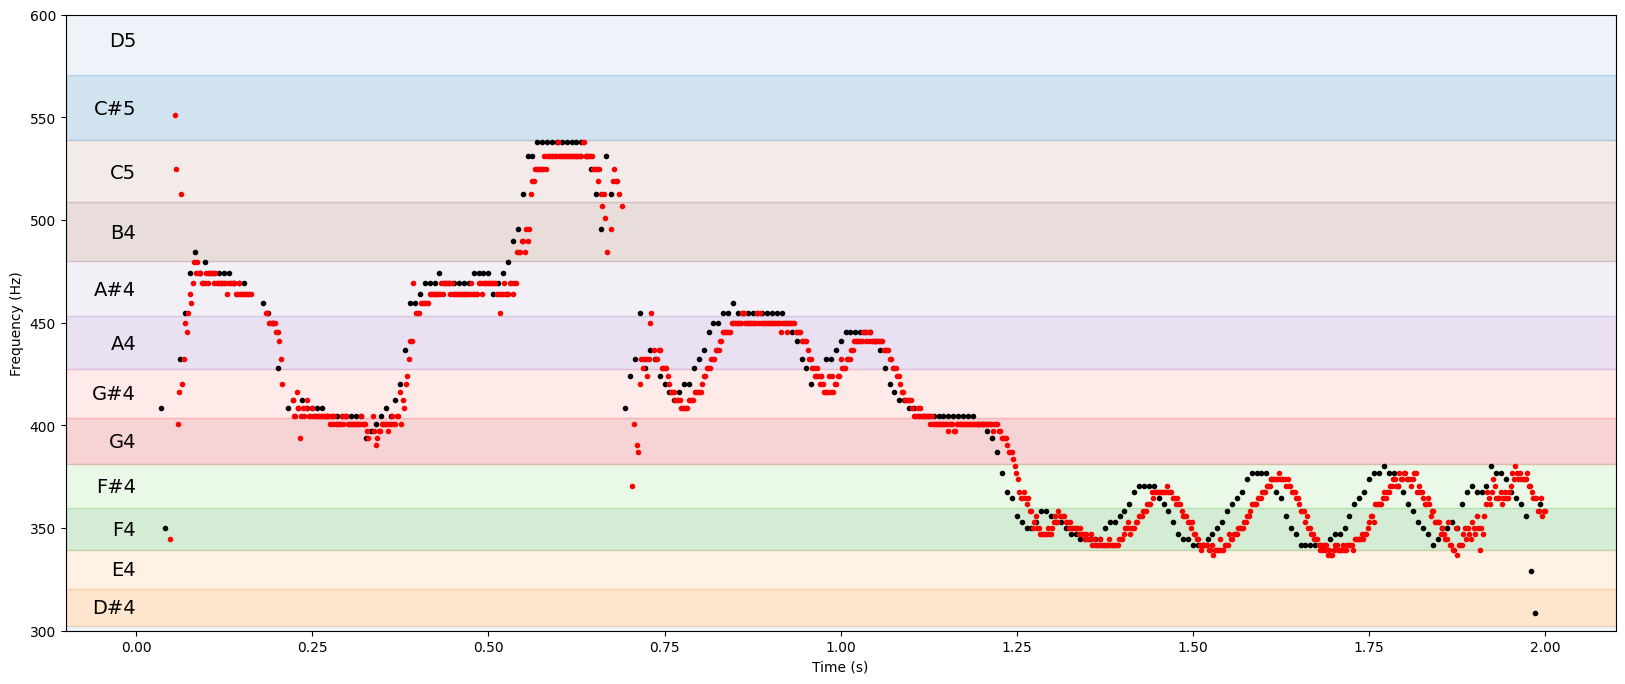

In [133]:
x1 = np.linspace(0, len(data)//sample_rate, num = len(pitches))
x2 = np.linspace(0, len(data)//sample_rate, num = len(pitches_memo))
plt.figure(figsize=(20,8))
plot_note_intervals(fmin=300, fmax=600)
plt.plot(x1,pitches,'.k')
plt.plot(x2,pitches_memo,'.r')
plt.ylim(300,600)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [88]:
sample_rate_piano, data_piano = wavfile.read(f'audios\lidio.wav')
data_piano = data_piano.astype(np.float64)
data_piano = data_piano[:,0]
windows_size_piano = int(5 / 2000 * 16000)
bounds_piano = [ 20, 2000 ]

pitches_memo_piano = []

for i in tqdm(range (data_piano.shape[0] // (windows_size_piano+3))):
    pitches_memo_piano.append(augmented_detect_pitch_CMNDF(data_piano, windows_size_piano, i * windows_size_piano, sample_rate_piano, bounds_piano))

  0%|          | 0/1984 [00:00<?, ?it/s]C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_15608\306576684.py:34: RuntimeWarning: invalid value encountered in scalar divide
  vals.append(DF(f, W, t, lag) / running_sum * lag)
100%|██████████| 1984/1984 [01:04<00:00, 30.92it/s]


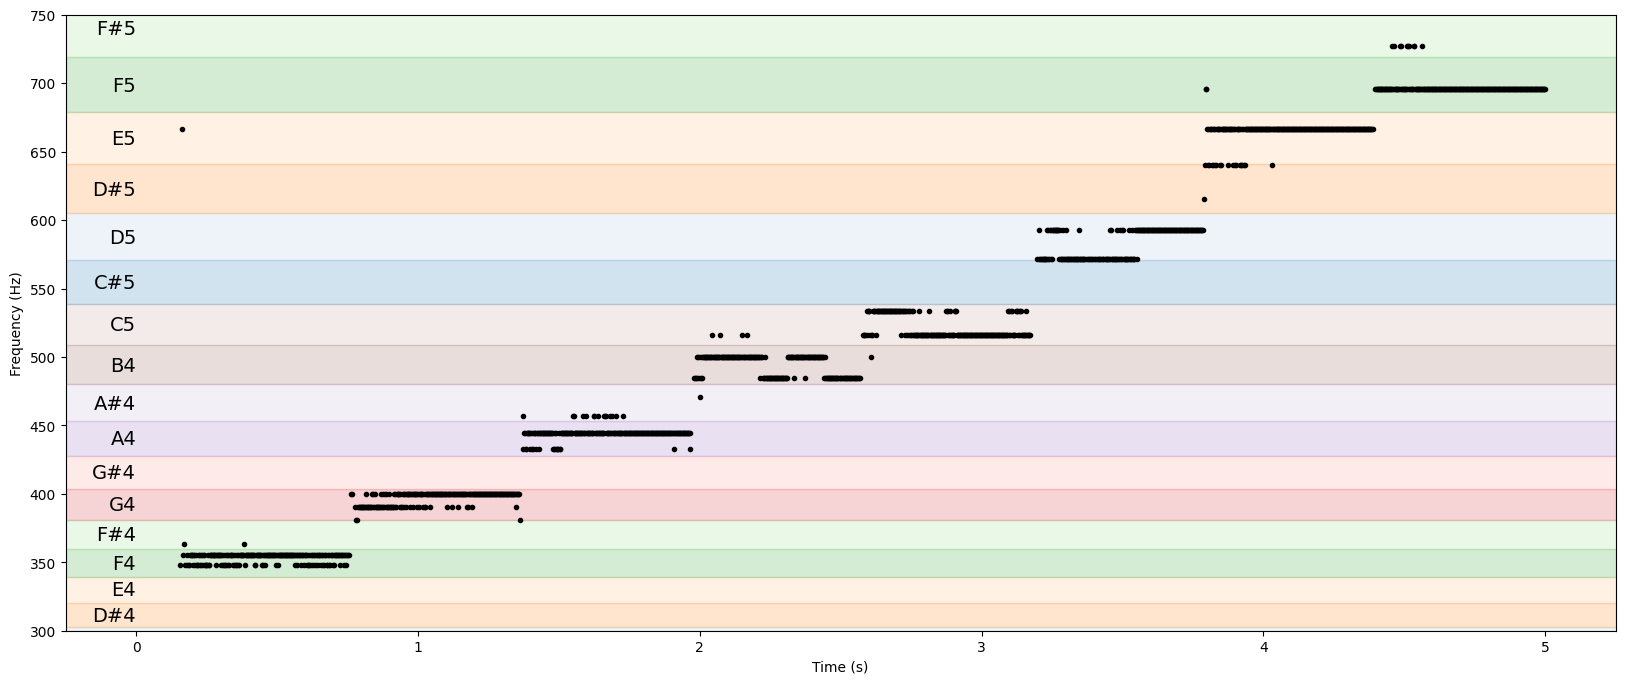

In [134]:
x_piano = np.linspace(0,len(data_piano)//sample_rate_piano, num=len(pitches_memo_piano))
plt.figure(figsize=(20,8))
plot_note_intervals(fmin=300, fmax=750)
plt.plot(x_piano,pitches_memo_piano,'.k')
plt.ylim(300,750)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()